In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_all = pd.read_pickle('data.pickle')
# 初始化列为 float 类型
df_all['hour_likeCount'] = 0.0
df_all['hour_watchCount'] = 0.0

# 创建布尔索引，标识 live_time_last 不为 0 的行，避免出现0而得到无限大的数值
valid_indices = df_all['live_time_last'] != 0

# 使用布尔索引和向量化操作计算 hour_watchCount 和 hour_likeCount
df_all.loc[valid_indices, 'hour_watchCount'] = (df_all.loc[valid_indices, 'watchCount'] / df_all.loc[valid_indices, 'live_time_last']) * 3600
df_all.loc[valid_indices, 'hour_likeCount'] = (df_all.loc[valid_indices, 'likeCount'] / df_all.loc[valid_indices, 'live_time_last']) * 3600

# 输出平均值
print(df_all['hour_likeCount'].mean(), df_all['hour_watchCount'].mean())

346.223123004971 674.5854626903632


In [3]:
for column in df_all.columns:
    # 空值
    null_count = df_all[column].isnull().sum()

    # 检查字段类型是否为数值型
    if pd.api.types.is_numeric_dtype(df_all[column]):
        # 最大值
        max_value = df_all[column].max()
        
        # 最小值
        min_value = df_all[column].min()
        
        # 平均值
        mean_value = df_all[column].mean()
        
        # 打印字段信息
        print(f"字段名: {column}")
        print(f"空值数量: {null_count}")
        print(f"最大值: {max_value}")
        print(f"最小值: {min_value}")
        print(f"平均值: {mean_value}")
        print(f'字段类型：{type(column)}')
        print()
    else:
        print(f"字段名: {column}")
        print(f"空值数量: {null_count}")
        print("字段不是数值型，无法计算最大值、最小值和平均值")
        print(f'字段类型：{type(column)}')
        print()

字段名: liveId
空值数量: 0
字段不是数值型，无法计算最大值、最小值和平均值
字段类型：<class 'str'>

字段名: isFinish
空值数量: 0
最大值: True
最小值: False
平均值: 0.9999950775985819
字段类型：<class 'str'>

字段名: isFull
空值数量: 0
最大值: True
最小值: False
平均值: 0.938876695690376
字段类型：<class 'str'>

字段名: parentArea
空值数量: 0
字段不是数值型，无法计算最大值、最小值和平均值
字段类型：<class 'str'>

字段名: area
空值数量: 0
字段不是数值型，无法计算最大值、最小值和平均值
字段类型：<class 'str'>

字段名: coverUrl
空值数量: 0
字段不是数值型，无法计算最大值、最小值和平均值
字段类型：<class 'str'>

字段名: danmakusCount
空值数量: 0
最大值: 275257
最小值: 0
平均值: 1189.399399343967
字段类型：<class 'str'>

字段名: startDate
空值数量: 0
最大值: 1715780200000
最小值: 1580867858000
平均值: 1677069047865.2517
字段类型：<class 'str'>

字段名: stopDate
空值数量: 0
最大值: 1715786365542
最小值: 1580869911000
平均值: 1677080696244.3796
字段类型：<class 'str'>

字段名: title
空值数量: 0
字段不是数值型，无法计算最大值、最小值和平均值
字段类型：<class 'str'>

字段名: totalIncome
空值数量: 0
最大值: 9210992.4
最小值: 0.0
平均值: 779.8671695022778
字段类型：<class 'str'>

字段名: watchCount
空值数量: 0
最大值: 554220
最小值: 0
平均值: 1725.0120389632684
字段类型：<class 'str'>

字段名: likeCount
空值数量: 0
最大值: 2

In [4]:
df_all['month'] = df_all['start_live_time'].dt.to_period('D').dt.to_timestamp()
# 去掉23年9月后的数据
filter_date = pd.to_datetime('2023-09-01')
df_all_after_timesplit = df_all[df_all['month'] < filter_date]

## 发现很多异常数据：有些主播的收入过高，原因是礼物数量计数错误

解决办法

- 根据主播名分组
- 四分位检测
- zscore
- log化
- 中位数填充

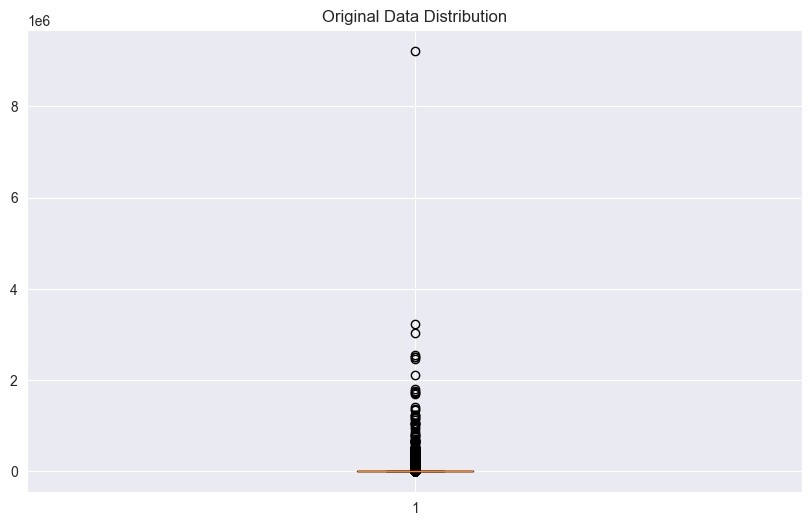

C:\Users\棒\AppData\Local\Temp\ipykernel_9352\3720418782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'log_{column}'] = np.log(df[column] + 1)
C:\Users\棒\AppData\Local\Temp\ipykernel_9352\3720418782.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['z_score'] = np.abs(stats.zscore(df[column]))


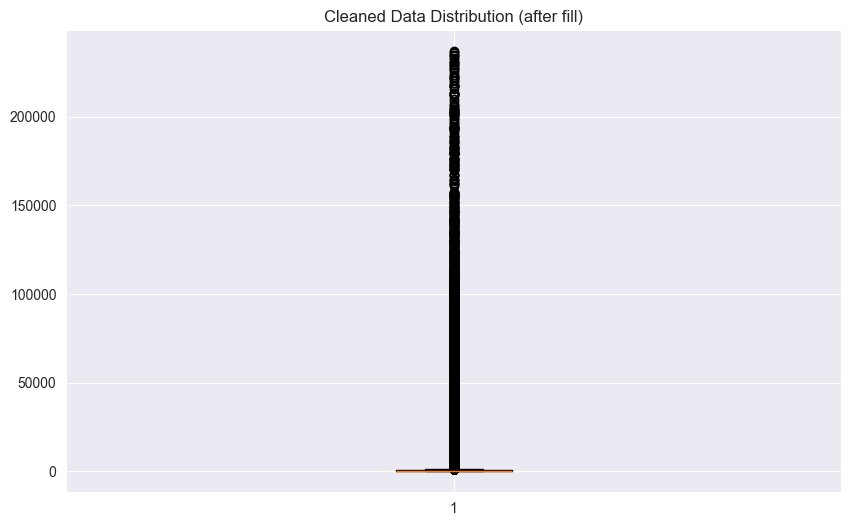

In [5]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# 定义对数据进行对数变换的函数
def log_transform(df, column):
    df[f'log_{column}'] = np.log(df[column] + 1)
    return df

# IQR方法检测异常值
def detect_outliers_iqr(df, column, outlier_thresh=3.0):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - outlier_thresh * IQR
    upper_bound = Q3 + outlier_thresh * IQR
    iqr_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return iqr_outliers

# Z-score方法检测异常值
def detect_outliers_zscore(df, column, z_thresh=3):
    df['z_score'] = np.abs(stats.zscore(df[column]))
    z_outliers = df[df['z_score'] > z_thresh]
    return z_outliers

# 结合IQR和Z-score两种方法检测异常值
def detect_outliers_combined(df, column, iqr_thresh=1.5, z_thresh=3):
    df = log_transform(df, column)
    iqr_outliers = detect_outliers_iqr(df, f'log_{column}', iqr_thresh)
    z_outliers = detect_outliers_zscore(df, f'log_{column}', z_thresh)
    
    combined_outliers_index = iqr_outliers.index.intersection(z_outliers.index)
    return df.loc[combined_outliers_index]

# 绘制数据分布图
def plot_data_distribution(df, column, title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.boxplot(df[column])
    plt.show()

# 主方法：检测异常值并绘制分布图，补偿被删除的数据
def analyze_and_plot(data, column):
    # 原始数据分布
    plot_data_distribution(data, column, 'Original Data Distribution')

    # 检测异常值
    outliers = detect_outliers_combined(data, column)
    
    # 计算清洗后的中位数
    cleaned_data = data.drop(outliers.index)
    fill_value = cleaned_data[column].median()
    
    # 填充被删除的数据
    data.loc[outliers.index, column] = fill_value

    # 清洗后数据分布
    cleaned_data_after_fill = data
    plot_data_distribution(cleaned_data_after_fill, column, 'Cleaned Data Distribution (after fill)')

    return outliers, cleaned_data_after_fill

# 执行函数
outliers, cleaned_data = analyze_and_plot(df_all_after_timesplit, 'totalIncome')

In [6]:
# 随机打乱数据集
# cdr表示cleaned_data_ramdom
cdr = cleaned_data.sample(frac=1)

728939      5680.000
110009     14673.285
28686       9831.566
432385     15248.000
507804     16610.620
             ...    
157063      9324.035
795820     13826.705
717557     85844.417
904620     16977.606
1313293     8842.910
Name: live_time_last, Length: 1107676, dtype: float64
728939    2021-01-25 11:04:01
110009    2023-01-28 22:33:42
28686     2023-04-18 20:01:14
432385    2022-05-01 20:14:29
507804    2022-11-26 23:17:45
                  ...        
157063    2022-12-15 19:30:38
795820    2023-08-08 19:41:00
717557    2022-09-13 19:04:16
904620    2023-04-13 11:46:19
1313293   2023-02-15 09:31:40
Name: start_live_time, Length: 1107676, dtype: datetime64[ns]
728939    2021-01-25 12:38:41.000
110009    2023-01-29 02:38:15.285
28686     2023-04-18 22:45:05.566
432385    2022-05-02 00:28:37.000
507804    2022-11-27 03:54:35.620
                    ...          
157063    2022-12-15 22:06:02.035
795820    2023-08-08 23:31:26.705
717557    2022-09-14 18:55:00.417
904620    2023-04

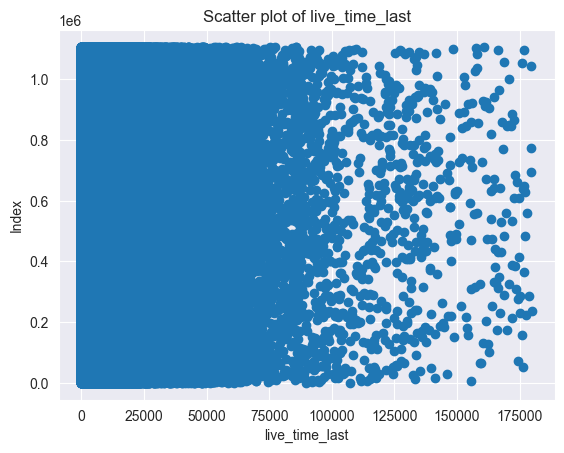

In [7]:
print(cdr['live_time_last'])
print(cdr['start_live_time'])
print(cdr['stop_live_time'])
import matplotlib.pyplot as plt
plt.scatter(cdr['live_time_last'], range(len(cdr)))
plt.ylabel('Index')
plt.xlabel('live_time_last')
plt.title('Scatter plot of '+'live_time_last')
plt.show()

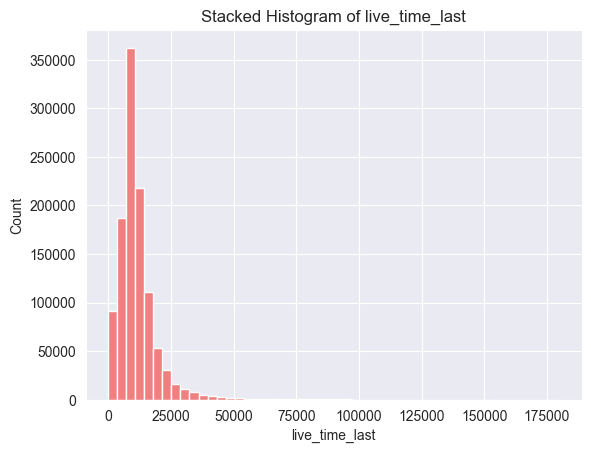

In [8]:
import matplotlib.pyplot as plt

plt.hist(cdr['live_time_last'], bins = 50, stacked=True, color='lightcoral')
plt.xlabel('live_time_last')
plt.ylabel('Count')
plt.title('Stacked Histogram of '+'live_time_last')
plt.show()

In [9]:
max_row = df_all.loc[df_all['live_time_last'].idxmax()]
print(max_row)

liveId                                       b41e2dfb-38ef-44b2-961c-dd418c6740d0
isFinish                                                                     True
isFull                                                                       True
parentArea                                                                   未知分区
area                                                                         未知分区
coverUrl                        https://i0.hdslb.com/bfs/live/new_room_cover/a...
danmakusCount                                                                1086
startDate                                                           1607500025000
stopDate                                                            1607679948000
title                                                                      =w= 惬意
totalIncome                                                                 14.56
watchCount                                                                    163
likeCount       

然而不可思议的是这个直播了将近五十个小时的数据居然不是异常值

<img src="https://p1.meituan.net/csc/73979ac50715ef6c47e9952f9f6b925a5275328.png" width="1280" height="700">

（弹幕数据也是可查的）https://laplace.live/stats/2362016/b41e2dfb-38ef-44b2-961c-dd418c6740d0

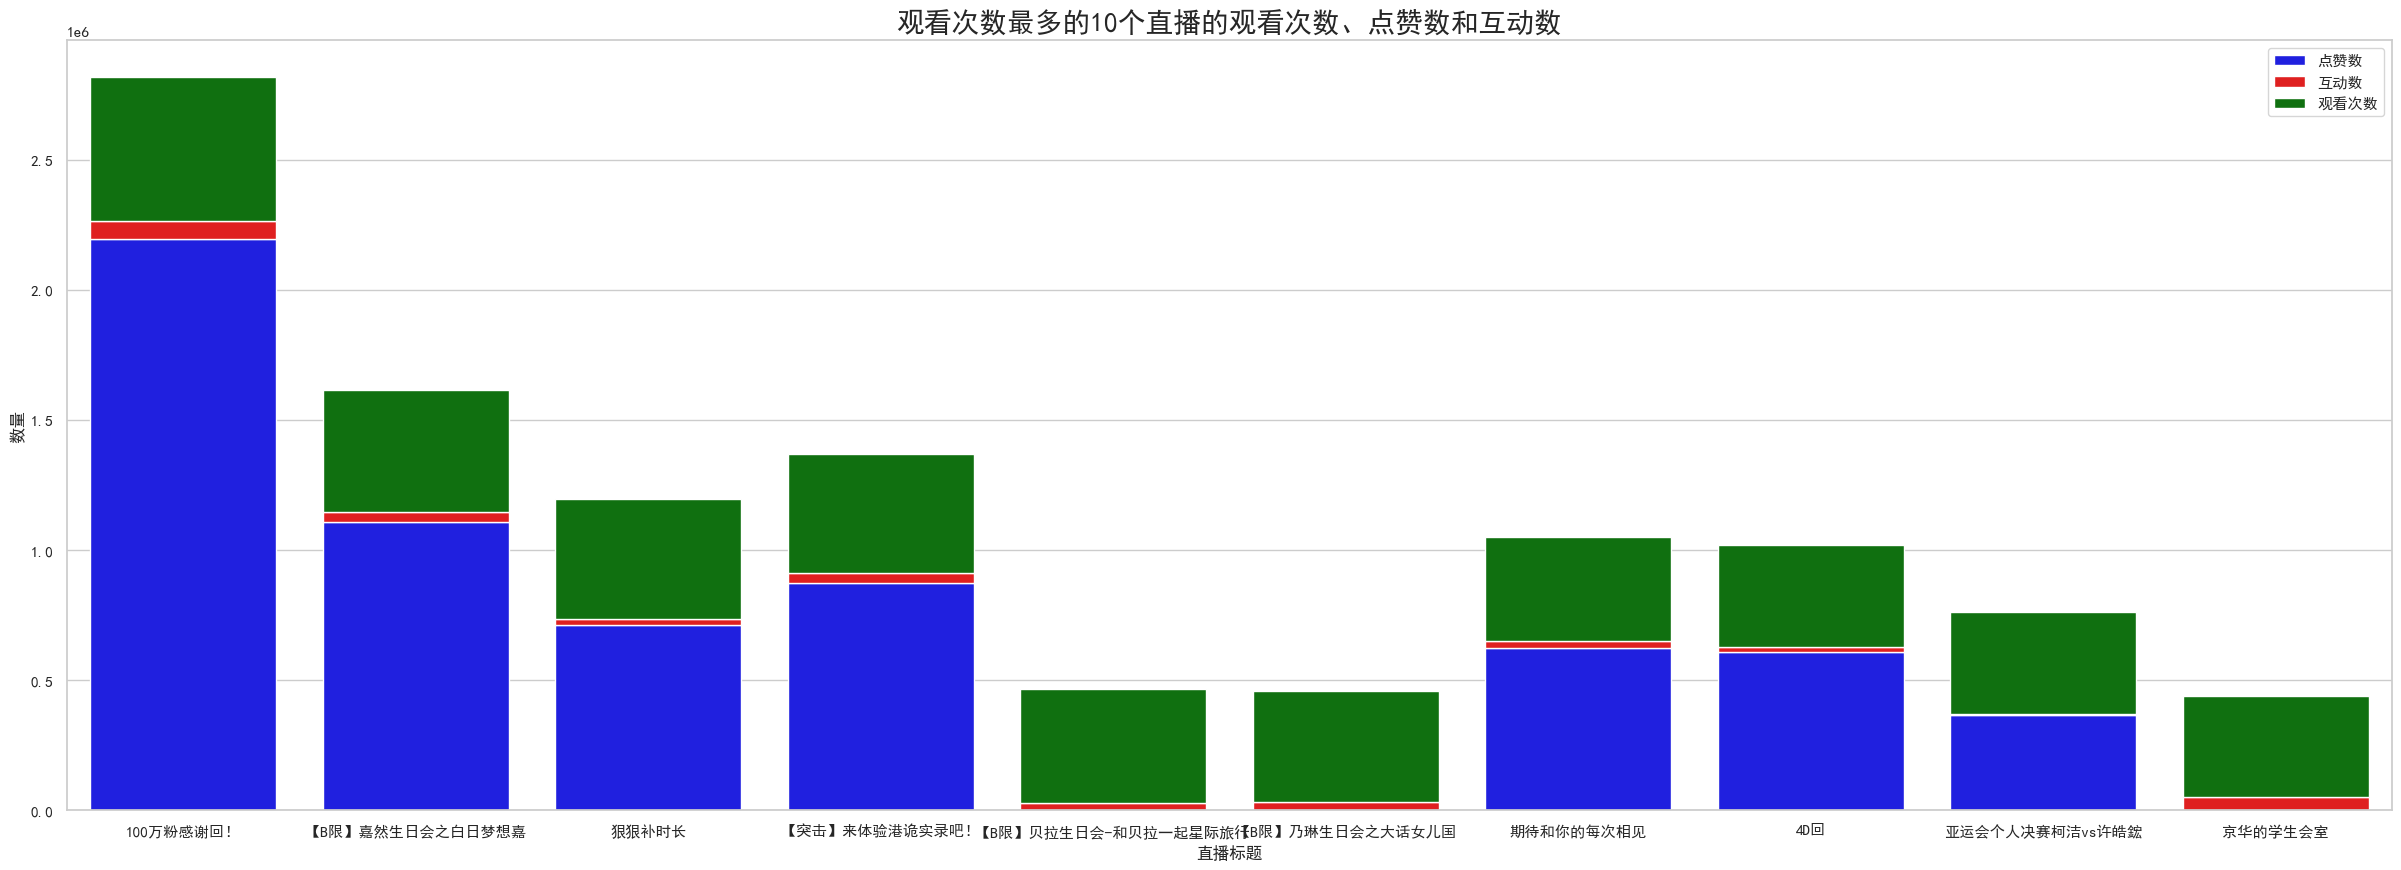

In [10]:
import seaborn as sns

# 创建一个新的Dataframe
data = {'watchCount': [554220, 470168, 460906, 455222, 439796, 428792, 402579, 394542, 391258, 385719],
        'likeCount': [2195076, 1107738, 711368, 875781, 0, 0, 623268, 610691, 368025, 0],
        'interactionCount': [68146, 37063, 24083, 37911, 28412, 31417, 25889, 15556, 3664, 52309],
        'title': ['100万粉感谢回！', '【B限】嘉然生日会之白日梦想嘉', '狠狠补时长', '【突击】来体验港诡实录吧！',
                  '【B限】贝拉生日会-和贝拉一起星际旅行', '【B限】乃琳生日会之大话女儿国', '期待和你的每次相见', '4D回',
                  '亚运会个人决赛柯洁vs许皓鋐', '京华的学生会室']}
df = pd.DataFrame(data)

# 设置风格
sns.set_theme(style='whitegrid')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 开始绘图
plt.figure(figsize=(30, 10))
plt.title('观看次数最多的10个直播的观看次数、点赞数和互动数', fontsize=20)

# 创建堆叠的条形图
sns.barplot(x='title', y='likeCount', data=df, color='blue', label='点赞数')
sns.barplot(x='title', y='interactionCount', data=df, color='red', bottom = df.likeCount, label='互动数')
sns.barplot(x='title', y='watchCount', data=df, color='green', bottom = df.likeCount + df.interactionCount, label='观看次数')

# 设置图例和标签
plt.legend()
plt.xlabel('直播标题')
plt.ylabel('数量')
plt.show()

In [11]:
grouped_df = cdr.groupby('channel_uName')[['watchCount', 'likeCount', 'interactionCount', 'totalIncome']]
grouped_df_sum = grouped_df.sum()
grouped_df_sum = grouped_df_sum.reset_index()

sorted_by_watchCount = grouped_df_sum.sort_values(by='watchCount', ascending=False)
sorted_by_likeCount = grouped_df_sum.sort_values(by='likeCount', ascending=False)
sorted_by_interactionCount = grouped_df_sum.sort_values(by='interactionCount', ascending=False)
sorted_by_totalIncome = grouped_df_sum.sort_values(by='totalIncome', ascending=False)

print('观看数排行')
print(sorted_by_watchCount.head(20))
print()
print('点赞数排行')
print(sorted_by_likeCount.head(20))
print()
print('互动数排行')
print(sorted_by_interactionCount.head(20))
print()
print('收益排行')
print(sorted_by_totalIncome.head(20))

观看数排行
       channel_uName  watchCount  likeCount  interactionCount  totalIncome
70           Asaki大人    71720842   50642746           6041786   7701743.70
101             C酱です    68806913   13466812           5769713   4433357.40
2880            永雏塔菲    50924707    8085451           4334730   6316319.92
3504   眞白花音_Official    43420906   16337503           3773863   6906970.46
4654        阿梓从小就很可爱    38778318    4711862           5287620   9595773.66
501        七海Nana7mi    34930043    3281937           3863598  13412388.02
368           hanser    28602857   29778963           3230596   2584902.00
4671           阿萨Aza    27299499   33432910           4358337  12681029.10
4047          花花Haya    25960953    2448374           2099059   3755581.56
138      HiiroVTuber    25482187    2964191           3713721   4185330.78
409        shourei小N    22764006    9469728           1406897   1610233.80
887             冰糖IO    20604247    1532945           2582751   6578937.09
4753    雫るる_Officia

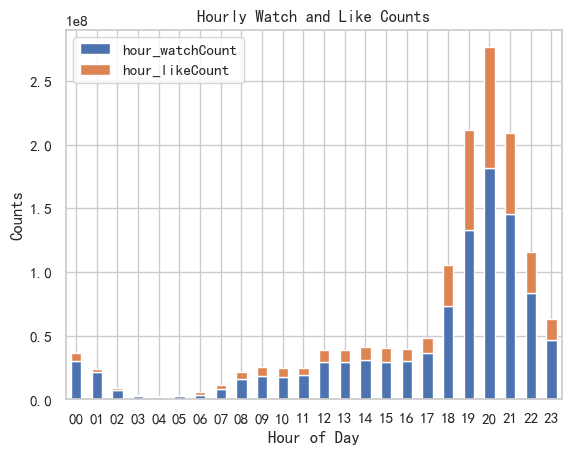

In [12]:
cdr['start_live_time'] = pd.to_datetime(cdr['start_live_time'])
cdr['stop_live_time'] = pd.to_datetime(cdr['stop_live_time'])

# 提取小时部分
cdr['hour'] = cdr['start_live_time'].dt.strftime('%H')

# 使用小时进行分组，并计算hour_watchCount和hour_likeCount的总值
hourly_totals = cdr.groupby('hour').agg({'hour_watchCount': 'sum', 'hour_likeCount': 'sum'})
hourly_totals.plot(kind='bar', stacked=True)
# 添加标题和标签
plt.title('Hourly Watch and Like Counts')
plt.xlabel('Hour of Day')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.show()

In [13]:
grouped = cdr.groupby(['channel_uId', 'channel_uName']).agg({'totalIncome': 'sum', 'title': 'count'}).reset_index()

# 计算每个主播每次直播的平均收益
grouped['avgIncomePerLive'] = grouped['totalIncome'] / grouped['title']
grouped.rename(columns={'title': 'live_times'}, inplace=True)
grouped_sorted = grouped.sort_values(by='avgIncomePerLive', ascending=False)
print('——————————直播效益前二十————————————')
print(grouped_sorted.head(20))

——————————直播效益前二十————————————
           channel_uId    channel_uName  totalIncome  live_times  \
4055        1775966996  Vox_EN_Official    904696.70          13   
3827        1544125954   Mysta_Official    249274.10           4   
3887        1601895109   shoto_official    813873.40          15   
3170         672342685          乃琳Queen   4670087.56         172   
3172         672353429           贝拉kira   4399723.80         173   
2277         351609538          珈乐Carol   1752085.32          69   
3570        1281805827  Fulgur_Official    197604.40           8   
3169         672328094          嘉然今天吃什么   5010303.08         213   
2315         364225566        战斗吧歌姬官方账号   1363978.59          64   
3171         672346917            向晚大魔王   3607560.50         171   
5007  3494357252442916     RO姬_Official    634757.80          32   
2435         401315430      星瞳_Official   2916958.00         168   
2058         194484313          Asaki大人   7701743.70         478   
3951        166977

<Axes: xlabel='parentArea'>

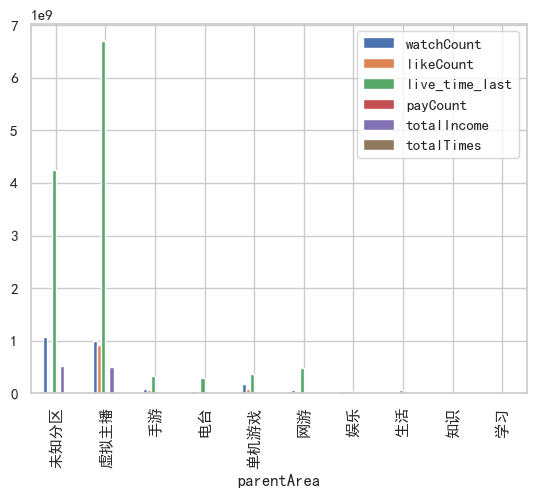

In [14]:
grouped_area = cdr.groupby('parentArea').agg({'watchCount': 'sum', 'likeCount': 'sum', 'live_time_last': 'sum', 'payCount': 'sum', 'totalIncome': 'sum', 'channel_roomId': 'count'})
grouped_area.rename(columns={'channel_roomId': 'totalTimes'}, inplace=True)
grouped_area_sorted = grouped_area.sort_values(by='totalIncome', ascending=False)
plt.rcParams['font.sans-serif'] = ['SimHei']
grouped_area_sorted[0:10].plot(kind='bar')

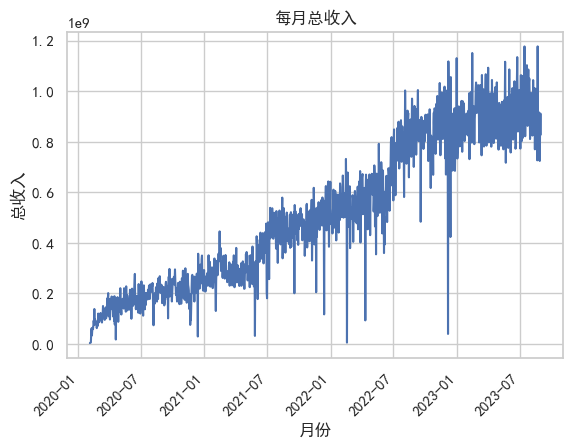

In [15]:
grouped_month = cdr.groupby('month').agg({ 'channel_totalIncome': 'sum'})

# new_grouped_sorted = new_grouped.sort_values(by = 'channel_totalIncome', ascending=False)
# print(new_grouped_sorted)
grouped_month.plot(kind = 'line', legend = False)
plt.title('每月总收入')
plt.xlabel('月份')
plt.ylabel('总收入')
plt.grid(True)
plt.xticks(rotation=45)  # 旋转横轴标签以提高可读性
plt.show()

In [16]:
print(cdr.columns)

Index(['liveId', 'isFinish', 'isFull', 'parentArea', 'area', 'coverUrl',
       'danmakusCount', 'startDate', 'stopDate', 'title', 'totalIncome',
       'watchCount', 'likeCount', 'payCount', 'interactionCount',
       'maxOnlineCount', 'code', 'message', 'channel_uId', 'channel_uName',
       'channel_roomId', 'channel_faceUrl', 'channel_frameUrl',
       'channel_isLiving', 'channel_title', 'channel_tags',
       'channel_lastLiveDate', 'channel_lastLiveDanmakuCount',
       'channel_totalDanmakuCount', 'channel_totalIncome',
       'channel_totalLiveCount', 'channel_totalLiveSecond', 'channel_addDate',
       'channel_commentCount', 'channel_lastLiveIncome', 'start_live_time',
       'stop_live_time', 'live_time_last', 'hour_likeCount', 'hour_watchCount',
       'month', 'log_totalIncome', 'z_score', 'hour'],
      dtype='object')


# 数据挖掘思路
## 字段解释

带-的不用管

|字段|解释|
|:--:|:--:|
|liveId|直播id|
|isFinish|-| 
|isFull|-|
|parentArea|主分区|
|area|子分区|
|coverUrl|-|
|danmakusCount|本场弹幕数|
|startDate|本场开始时间|
|stopDate|本场结束时间|
|title|本场直播标题|
|totalIncome|本场直播收入|
|watchCount|本场观看数|
|likeCount|本场点赞数（22年9月才开始记录）|
|payCount|本场礼物数|
|interactionCount|本场互动数|
|maxOnlineCount|本场最高在线人数|
|code|-|
|message|-|
|channel_uId|主播uid|
|channel_uName|主播名|
|channel_roomId|直播房间号|
|channel_faceUrl|-|
|channel_frameUrl|-|
|channel_isLiving|-|
|channel_title|频道标题|
|channel_tags|频道tag|
|channel_lastLiveDate|主播上次开播时间|
|channel_lastLiveDanmakuCount|主播上次弹幕数|
|channel_totalDanmakuCount|主播弹幕总数|
|channel_totalIncome|主播总收入|
|channel_totalLiveCount|主播总场次|
|channel_totalLiveSecond|主播总时长|
|channel_addDate|最初开播时间|
|channel_commentCount|频道总评论数|
|channel_lastLiveIncome|主播上次直播收入|
|start_live_time|本场开始时间（和上面那个格式不同）|
|stop_live_time|本场结束时间|
|live_time_last|本场时长|
|hour_likeCount|本场平均每小时点赞|
|hour_watchCount|本场平均每小时观看|
|month|本场所在年月|
|log_totalIncome|对数化的本场收入|
|z_score|-|
|hour|本场开播时间（24小时制）|

## 无监督

### 聚类算法

选一个合适（给出所有算法的结果，选一个效果好的）的聚类算法对所有数据记录聚类（算法+评价指标）。这个聚类直接聚就完了，意义只是怎么解释聚类完的结果，因为这个聚类是不带监督指标的

### 关联规则

分两步走：
- 本场数据指标的关联
- 频道/主播指标关联
（意思是要把这些分开做，因为一个主播有多场直播，不过本场数据指标可能可以考虑频道指标，这个得试试）

把非数值型的字段先二元化，再做分析

想办法指定前后项（问问gpt吧，理论上可以把除了收入之外的字段标注为输入与输出（可能要考虑加不加id），收入这样的标为仅输入）

## 带监督

### 分类算法

分类机特别多（这里包括了神经网络），但是可以根据一套标准来进行评价（f值，混淆矩阵，roc曲线和auc值）

朴素贝叶斯，KNN，决策树，逻辑回归，网上一查一大堆

先构造一个合理的监督指标y，建议复制一下上面的所有字段解释问一下gpt（可以试试多搞几个y，相当于找不同的角度，每个y做一次）

再挑X（最好不要一次放完所有字段）

### 回归

很多分类机有回归功能，比如crt这种，所以不用专门弄，但是要在分类算法里注明哪些是y用的是回归

### 文本

先弄完上面的再说吧。。。


## 聚类算法——K-means

In [17]:
# 从 cdr 中随机抽取一万条记录
sample_cdr = cdr.sample(n=10000, random_state=42)

# 输出抽样后的数据集大小
print(sample_cdr.head(3))

# 可选：保存抽样后的数据集到文件
# sample_cdr.to_csv('sample_cdr.csv', index=False)  # 将抽样后的数据集保存到 CSV 文件中，不保存行索引


                                      liveId  isFinish  isFull parentArea  \
368651  02013305-6673-4260-a77c-3595f0eefdb1      True    True       虚拟主播   
767879  7e829cf6-f035-4a6f-8dfe-8ed2a444eb61      True    True       虚拟主播   
381074  dd65c2ee-0bab-4225-aabd-4e563f920da4      True    True       虚拟主播   

        area                                           coverUrl  \
368651  虚拟主播  https://i0.hdslb.com/bfs/live/new_room_cover/6...   
767879  虚拟日常  https://i0.hdslb.com/bfs/live/new_room_cover/3...   
381074  虚拟日常  https://i0.hdslb.com/bfs/live/new_room_cover/3...   

        danmakusCount      startDate       stopDate              title  ...  \
368651            159  1671898715000  1671902360047       一个人的圣诞 周末杂谈回  ...   
767879            769  1681391208000  1681398968317              是汪汪猫！  ...   
381074            763  1690435151000  1690444397651  【LOL】沉默单排Time欢迎黑听  ...   

        channel_lastLiveIncome     start_live_time          stop_live_time  \
368651                     

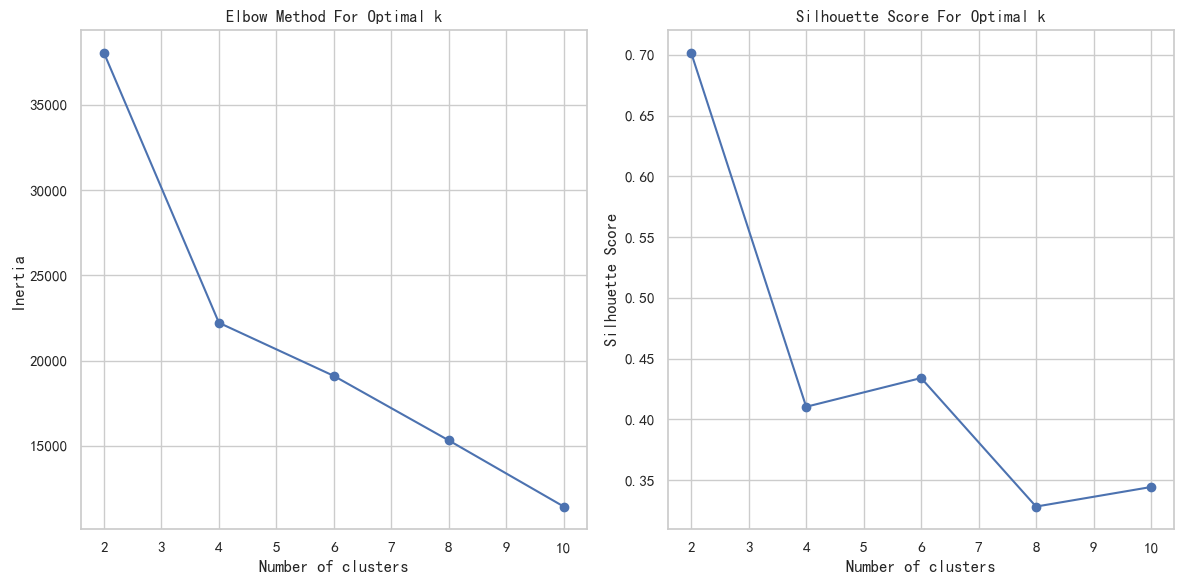

In [18]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 选择用于聚类的字段（所有数值型字段）
features = [
    'channel_totalDanmakuCount',
    'channel_totalIncome',
    'channel_totalLiveCount',
    'channel_totalLiveSecond',
    'channel_commentCount',
]

# 2. 提取特征数据
X = sample_cdr[features].dropna()  # 去掉包含缺失值的行

# 3. 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. 使用肘部法则确定最佳聚类数
inertia = []
silhouette_scores = []
K = range(2, 11, 2)  # 减少迭代次数，增加步长
for k in K:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=100)  # 使用 MiniBatchKMeans
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# 绘制肘部法则图
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')

# 绘制轮廓系数图
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')

plt.tight_layout()
plt.show()


Optimal number of clusters: 2
                                       liveId  isFinish  isFull parentArea  \
368651   02013305-6673-4260-a77c-3595f0eefdb1      True    True       虚拟主播   
767879   7e829cf6-f035-4a6f-8dfe-8ed2a444eb61      True    True       虚拟主播   
381074   dd65c2ee-0bab-4225-aabd-4e563f920da4      True    True       虚拟主播   
123442   c0ff75d2-d4f4-49f8-8cd5-d850d2a27f27      True    True       虚拟主播   
1077382  642c68e7-b977-4da5-a1af-aabe6900e9e7      True    True       虚拟主播   

            area                                           coverUrl  \
368651      虚拟主播  https://i0.hdslb.com/bfs/live/new_room_cover/6...   
767879      虚拟日常  https://i0.hdslb.com/bfs/live/new_room_cover/3...   
381074      虚拟日常  https://i0.hdslb.com/bfs/live/new_room_cover/3...   
123442   虚拟Gamer  https://i0.hdslb.com/bfs/live/new_room_cover/7...   
1077382     虚拟PK  https://i0.hdslb.com/bfs/live/new_room_cover/a...   

         danmakusCount      startDate       stopDate              title  .

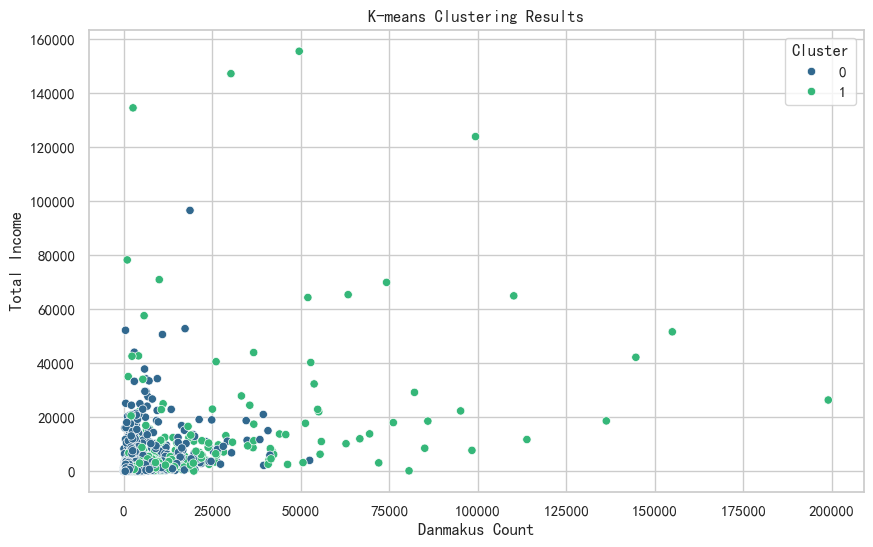

In [19]:
# 5. 选择合适的聚类数并进行K-means聚类
optimal_k = K[silhouette_scores.index(max(silhouette_scores))]
print(f'Optimal number of clusters: {optimal_k}')

kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=100)
kmeans.fit(X_scaled)

# 6. 获取聚类标签
labels = kmeans.labels_

# 7. 将聚类标签添加到原数据框中，但不保存到文件
sample_cdr['cluster'] = labels  # 只给没有缺失值的行添加聚类标签

# 8. 在Jupyter Notebook中展示结果
# 展示前5行聚类结果
print(sample_cdr.head())

# 可视化聚类结果
# 这里以 'danmakusCount' 和 'totalIncome' 为例
plt.figure(figsize=(10, 6))
sns.scatterplot(x='danmakusCount', y='totalIncome', hue='cluster', data=sample_cdr, palette='viridis')
plt.title('K-means Clustering Results')
plt.xlabel('Danmakus Count')
plt.ylabel('Total Income')
plt.legend(title='Cluster')
plt.show()

## 聚类算法——DBSCAN

                                       liveId  isFinish  isFull parentArea  \
368651   02013305-6673-4260-a77c-3595f0eefdb1      True    True       虚拟主播   
767879   7e829cf6-f035-4a6f-8dfe-8ed2a444eb61      True    True       虚拟主播   
381074   dd65c2ee-0bab-4225-aabd-4e563f920da4      True    True       虚拟主播   
123442   c0ff75d2-d4f4-49f8-8cd5-d850d2a27f27      True    True       虚拟主播   
1077382  642c68e7-b977-4da5-a1af-aabe6900e9e7      True    True       虚拟主播   

            area                                           coverUrl  \
368651      虚拟主播  https://i0.hdslb.com/bfs/live/new_room_cover/6...   
767879      虚拟日常  https://i0.hdslb.com/bfs/live/new_room_cover/3...   
381074      虚拟日常  https://i0.hdslb.com/bfs/live/new_room_cover/3...   
123442   虚拟Gamer  https://i0.hdslb.com/bfs/live/new_room_cover/7...   
1077382     虚拟PK  https://i0.hdslb.com/bfs/live/new_room_cover/a...   

         danmakusCount      startDate       stopDate              title  ...  \
368651             159  

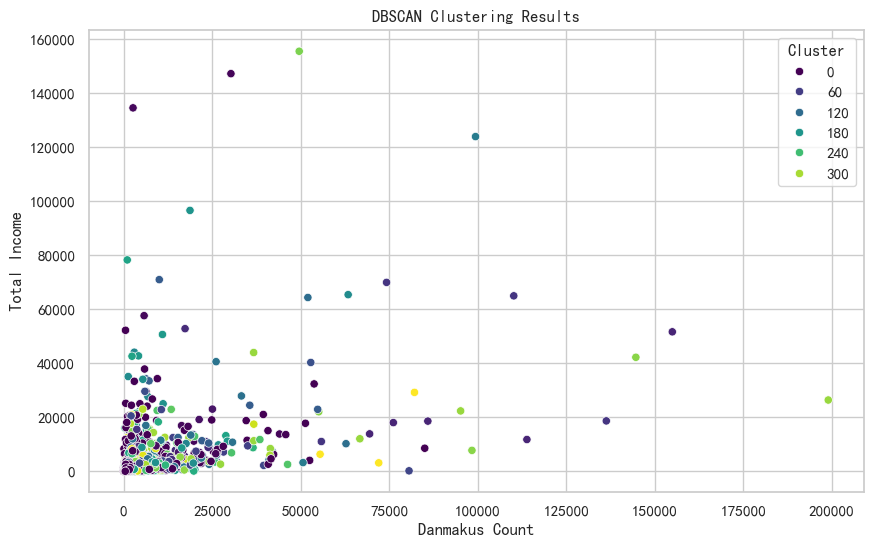

In [20]:
from sklearn.cluster import DBSCAN

# 选择用于聚类的字段（选择最重要的特征）
features = [
    'channel_totalDanmakuCount',
    'channel_totalIncome',
    'channel_totalLiveCount',
    'channel_totalLiveSecond',
    'channel_commentCount',
]

# 提取特征数据
X = sample_cdr[features].dropna()  # 去掉包含缺失值的行

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 调整 DBSCAN 参数
eps = 0.1  # 减小邻域半径
min_samples = 3  # 减小最小样本数

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(X_scaled)

# 获取聚类标签
labels = dbscan.labels_

# 将聚类标签添加到原数据框中，但不保存到文件
sample_cdr['cluster'] = labels  # 只给没有缺失值的行添加聚类标签

# 展示前5行聚类结果
print(sample_cdr.head())

# 可视化聚类结果
plt.figure(figsize=(10, 6))
sns.scatterplot(x='danmakusCount', y='totalIncome', hue='cluster', data=sample_cdr, palette='viridis')
plt.title('DBSCAN Clustering Results')
plt.xlabel('Danmakus Count')
plt.ylabel('Total Income')
plt.legend(title='Cluster')
plt.show()



## 聚类算法——层次聚类

                                       liveId  isFinish  isFull parentArea  \
368651   02013305-6673-4260-a77c-3595f0eefdb1      True    True       虚拟主播   
767879   7e829cf6-f035-4a6f-8dfe-8ed2a444eb61      True    True       虚拟主播   
381074   dd65c2ee-0bab-4225-aabd-4e563f920da4      True    True       虚拟主播   
123442   c0ff75d2-d4f4-49f8-8cd5-d850d2a27f27      True    True       虚拟主播   
1077382  642c68e7-b977-4da5-a1af-aabe6900e9e7      True    True       虚拟主播   

            area                                           coverUrl  \
368651      虚拟主播  https://i0.hdslb.com/bfs/live/new_room_cover/6...   
767879      虚拟日常  https://i0.hdslb.com/bfs/live/new_room_cover/3...   
381074      虚拟日常  https://i0.hdslb.com/bfs/live/new_room_cover/3...   
123442   虚拟Gamer  https://i0.hdslb.com/bfs/live/new_room_cover/7...   
1077382     虚拟PK  https://i0.hdslb.com/bfs/live/new_room_cover/a...   

         danmakusCount      startDate       stopDate              title  ...  \
368651             159  

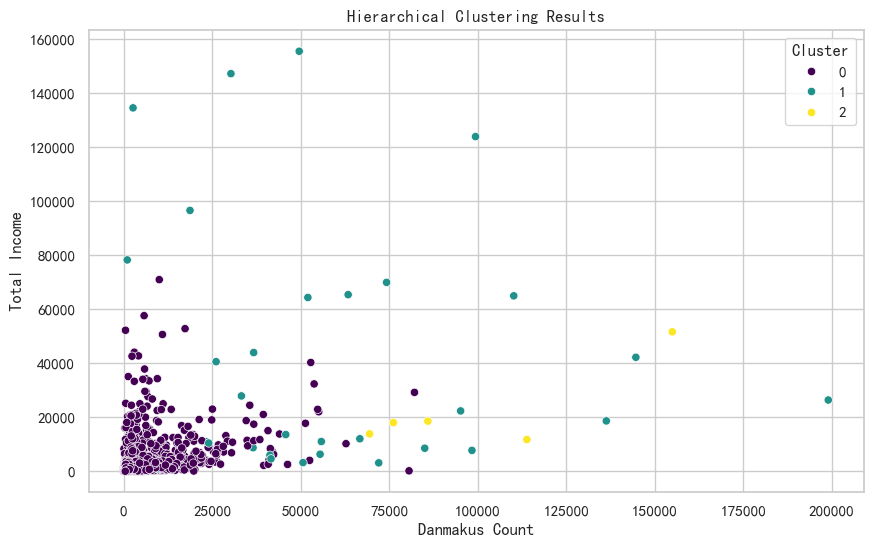

In [21]:
from sklearn.cluster import AgglomerativeClustering

# 选择用于聚类的字段（选择最重要的特征）
features = [
    'danmakusCount',
    'totalIncome',
    'likeCount',
    'payCount',
    'interactionCount',
    'maxOnlineCount',
]

# 提取特征数据
X = sample_cdr[features].dropna()  # 去掉包含缺失值的行

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 使用层次聚类
n_clusters = 3  # 聚类数

hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
hierarchical.fit(X_scaled)

# 获取聚类标签
labels = hierarchical.labels_

# 将聚类标签添加到原数据框中
sample_cdr['cluster'] = labels  # 只给没有缺失值的行添加聚类标签

# 在Jupyter Notebook中展示结果
# 展示前5行聚类结果
print(sample_cdr.head())

# 可视化聚类结果
plt.figure(figsize=(10, 6))
sns.scatterplot(x='danmakusCount', y='totalIncome', hue='cluster', data=sample_cdr, palette='viridis')
plt.title('Hierarchical Clustering Results')
plt.xlabel('Danmakus Count')
plt.ylabel('Total Income')
plt.legend(title='Cluster')
plt.show()



## 关联分析

收入作为前项,先探讨总体收入


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

cdr_all = sample_cdr[[
    'channel_totalDanmakuCount',
    'channel_totalIncome',
    'channel_totalLiveCount',
    'channel_totalLiveSecond',
    'channel_commentCount'
    ]]

# 替换缺失值为特定值（这里使用均值）
cdr_filled = cdr_all.fillna(cdr_all.mean())

# 选择用于关联分析的指标（这里将收入作为前项）
association_features = [
    'channel_totalDanmakuCount',
    'channel_totalLiveCount',
    'channel_totalLiveSecond',
    'channel_commentCount'
]

# 将数据转换成适合进行关联分析的格式
# 针对每个指标，将其值映射为0或1，表示出现或未出现
mlb = MultiLabelBinarizer()
cdr_binarized = mlb.fit_transform(cdr_filled[association_features].map(str))

# 将二进制数据转换为DataFrame
cdr_df = pd.DataFrame(cdr_binarized, columns=mlb.classes_)

# 使用Apriori算法找出频繁项集
frequent_itemsets = apriori(cdr_df, min_support=0.1, use_colnames=True)

# 根据频繁项集生成关联规则
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# 输出关联规则
print(rules)

C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


收入作为后项，探讨单次收入

In [25]:
# 替换缺失值为特定值（例如均值）
cdr_once = sample_cdr[[
    'danmakusCount',
    'totalIncome',
    'watchCount',
    'payCount',
    'interactionCount',
    'maxOnlineCount',
    'channel_lastLiveDate',
    'channel_lastLiveDanmakuCount',
    'channel_totalDanmakuCount',
    'channel_totalIncome',
    'channel_totalLiveCount',
    'channel_totalLiveSecond',
    'channel_commentCount',
    'channel_lastLiveIncome',
    'hour_likeCount',
    'hour_watchCount',
    'hour'
    ]]
cdr_filled = cdr_once.fillna(cdr_once.mean())

# 将所有非布尔值或非整数列转换为布尔值（0或1）
cdr_filled = (cdr_filled != 0) & (cdr_filled != 1)

# 选择用于关联分析的目标特征
association_features = ['totalIncome']

# 提取用于关联分析的特征
association_data = cdr_filled[association_features]

# 使用Apriori算法进行关联分析
frequent_itemsets = apriori(association_data, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# 显示关联规则
print(rules)

TypeError: Could not convert ['00211320201913222121201021180216202220182213211407091821202119212205192120212019211716142221212123202320181621202110202221141715192221222121222113200822122017202320222102192020222007191416061019211722232120150012191521191822182121102307002310181517141620072221202123122121202120192018190920122021191307171921000217182219022110202210222109182121192216191922172019202121001900220812142208121121211819121617112214191920212121221320201903150815002022180922141801212021111920201922031920001420201912212119191621211318020919102000071415212021201221121920071218192014212022202017191320202019191115221921132119212110212115211111191411212118140821221021202023222115202111160900152120211820212120192212212211202119202017222112152015192020102021182217202100092122212220062019211818212112152119152121222121210920172013131522201912221915181917182021202223091820202120171221210020212120202122202121201800141619211918202319102022221420071614222023181821202114160120182020211923222009192121120719200423222121211818192112180800101910072016161121190906202000112019192023230819012121201520212220171520212223171317221213130818211819181916211720172319031519181514201813192221211813170908071514221915181921191220082121212220212300122112192221212120171820101506020021002112201518172020151815081220201721211417192021221909120811191511152018072120160920201922172101160117201320192109071918212021120820182019231823082019231919162112211720141819201423161918231113192020212217202123001910212023202021092120181519200420130721221921231220212106171022202023122123201915201822202011202114082117201416222109092021191919202320192221121909191118201919172120062320221221202319101520212023201019142120222023200921061715231711001817222021002020122111192009200910151400201818111820181818151920190920141309102120201419211220181520091118162117161909212122141104211809212321141921081520192314202120231420001821201919200723202211031223152001202120222012222021191922190205202122191722001020122120211320221818201918132221192023142111151220182018202019201813152021201800202113221319181218100812192020131921181618222019201822141923120221092011222121201512202319102020190818182123200915212221212000221915142115172122190021201921211819090922221301112123172016082115092115181619182114202018151922101419201120200007201418211319201221212119210015222114192221190901191319170820192122212020092114002207222012201312191621201620192011192121201322061520100821191816162223201519111921221222212216201904221919212218221920092119092120081918160919152316222116202220220519202019182311141821171515161209121708162220182122121417182016002011202020191511210722211922001922101519152021202120201815221323221921191913201908192217130919212008202323082220111621171622211419151921212021202220012119141915132120032021022110142120152103192317221720130619201315202022202119212019221819212010120320001620202008201810222020201615181320001719201020201916141922210820202121201211171921011102211715101318201816192020211620070220192120182014141421220301181319212014171709121819202015161420191915210820172114191608192123152022202019112016211821180223192021212315200919192017202021141621182220032117211420231320212121211312211019202011172020121722182118152220202015212123161501122121202118201303002120211320192019220818232114110914211222090920232121121106092111052108210222201420142108061116201916160920232116221319180923131921162311211919202122210317191908062109101810202020212120201211181910232110231918211122201520230015221419191811202212000919202201112021201314152020231909212021102117201411231520211218202120212015202020192219201809081621131919212308092015211910200619201000222321212018211920192110111423212014212120070021172017201321211914232122232107161023061915161819151422212315202221152121191918211920181720131323212120192014211621142214210404190119191419141420201120211420201814192021192021201921202014151720212023191512172121192008151820081721212023222116192020222019231214161815212110102021211503192121002122202221191421182010222122112219190921041019190722202307072118201922211621231919132119182122170719201920201417181721151921212021102117201516091908221719182119141814151221181020190813062014201220121820231916212020212209082013201421192000232304191420011320192020211422201220192020212113200721190023201016192221191203191921181600201822192320182012081920212311210821192019222016112115180019202311221118211921222100152123201122171920211621141708112312182010182211222017210610181214212007141216161413002210210922122319222120191608142009181418182110100122092121162020052019191520222003152012070812212006232210181023230817222021191621222021221320222221202107172022141123231100232022202021201920192100202014161419192007211421182202031908221820212123202110221421191703091718152219132120201420102108230023200922221921092020111121192007012220202110192121180012121522211918002221212221190809202019202111211009201921162220221322062220002021201100202108152108202100201820162014181919192009191608160903192119142113212022212318111415212120132112211420201120211919212215142022041613202219132120202119182100142109182012202320200711151721210819162121230022121121201019212009092120132122191413192015211819152019152217132116082018190813192011202201191409231810170818152022161922131811151411091719191922192100202021161409211715091714232015171909221820202018081819201720172005182119212221202221000720212010201709231720232120081720231723200120202009081913211620200718191100171921150801201420192122192018201123032213211810211422142019182317222018102014102022192209002116101116200023160020181409151106212018211519211916221513191800211420212321192021202118161908162021211805192120182122200021212219201210172118222214200523211921230821232216230016142121221915201610120206212020201819202021201008172018212101191513222020081914212317212119192013132108200919202319221819152020182221130016201400202020202016201619202213012021022221192217102120222021191321081919182023142015122022122120010819201817142002202120190908202219202019121311202123201414232219121921210020211220201221192108212012201620162119162115201120152020221413201312152119200020200518191820222221141507021017230919202119190817192017202013221919202110032118200910201709201520150920211722011408121921202120191618211907212119182100010010011921212219202118131816192115222119192321121415182023122221192101202119202220202015201021092121072016052214190120211620082117061921192023221520212312192117212221192021201920211319092122192021201521222120201215141720062107171923011920202100171218122221200019192014212213212020151523211821210922202120212120212120181817161808202116201018131410202118130819181918092015140917192020232220172101061923222021212119132221141920100921091511001919210412170919182022212219212015111816211700160720171721022323012322071920210101202221212018092220190823191020202122200917180621162009072022202118202021211119072020100117172312011619162121212221210023151921041808102109221923151221190223151910202020211118222019201120200220222011072021081719221921211821191018211822111720212219212120202319091520192121201615212116202110162120161620211921201521202022191812201913201311171800232023202110212019191521072206152020211815210710211213162009162016101921231319141415181912142320112022191722142120221921211615162121212209191014222013212015221921202115202122100916220921022120232018142119191919181815221300202217191809101222092300202020210817171020192020192110092120011820181922211619181922191212221210211922202119211720191818182122201310200919191220141806102022201618221720200822201818102123142018140815201915001920191921211720142320212001190819171920180519201201222222202021201421200121232022201107142219231923221920091913201714142019211018221918181920222015222119202122192119201220211719091613192220201521202120082020222208141814101718212023152018212020201908210212081219222021082114191821231917181921120822202012041020201920131418201902101413192013191919161921112020232108082021211721212022141411182122201620192121120921211121081820210715202121222121202001222121171119221522232218191018181814221909212021201520222018181922092122201914161920192120141917081722082122211919230507092223121822092121231921212000201819201410192118212119112122102214191921122022202013160521201708132220201919212114202120200920231322221920202017192020202020212020172109222012152120212120122120141214161721101801142012142116202321181910142321211809141922112005120019162011161710141920191521191923212308212121211908201319191911141420191921171814201620142008211219001121202221220818202216222119212023192017091520182221081113142121172122171909221820202321222018191421222122211011211912231511191906231523171919181822211319191004180922202212171417092017152120130719221520212220212120231509211806222119191914201420191922192010210921141323191409210110222112112118151120230721201920162119190919202020211302231820120921172022102012122014222319160809180920231520151510102221141419211920200008151921191211071305210019211812211012192221092018211821160813192122222002191821121922202019180221202019182020202222222116201910161808212110211914202200201919212002200809230119202021012118211723121521122322170810212214181720220823151022232119192120180816210817212015142020142021142019182121192220200221181421030707222021202120192019222111221412182120200521201820192216202020192222172107222022121913212121181620191413001120092219211921092121221919142109211021091619142118221920212000201921202021211921191920111920142220221719212319141822192019221808202019160020202015192120222114141821202019211909191700010420212123202019191918212222201818181415212020211922192009191417211221200821212316232021152014182019052020101523202118191921211520101222182021210409222112221416101922221915202320111701171421192016172121200821211717211322200818182118102014212012202107101922202021211219231018212121202121232019072003191921220919011918201718161320202011151520202020202014212317092319140714201021172118202023192321222213141919101622091322200620140920172107211410211620212019152117232109202221201922232003211722002013202122090720202119202018012110212021131221202020222001212214071619201819210122160920162120211810212019181803202220212015231621191619062020170622201701122113232011151314132113172117202020002221222120111922221823192021222023212121211623222020231923152009152313201813192118222308231017170000232122200920190020181000212122151915112222180022191420231200202021192309222023182021092218221810192218222021002118002019020716081909161821200018092121151018011620210719222310222007132219182021190016191912221920172208191807161819081920220513201123151312111018180523181811232123191421212320201919042121221822202319202015201509181320201916082112152019142120210920081720210016151512212221200618141416221709202120101922201914191511111523221820212023092213201519101314151820062020142123202216122022202022202015201517152015191914192021202215200920161221141709081417201914172016221022161418171820202323132222221405112318192017092015211920142120180919162016192021211909212204150021151921152120182120180118202018061920041021120112202313232020131719182015220720192220012119191317152223002020132111202114202320212120231122161419201820191312152120201921152022221621221420202023001118202114162014212120152118222209092014112207211408221011201219181609162108231719192022171923132019162101122018211020201020221208192019061920050020202119221902152023182322012121222208202316192219091121070314081821202120191208152121072020142020210909201320231820131922202120222209232116201912180921212022152009221219122020152321210921082010230821202210200020162119222320202108121522121919220016192010221914201518211807221508191423191201201323081617231521211914202121101921222221232121222119192020101520222118081822211922200221201115181112212020152001200718202022211506000319200211192102230320212020161919202209222220192018211921182019212208102009211120210608221023201309212017170321172110191822002120141020162118121820201421191218192018081221181920142122201415102006221919202010201922210912171620202118112210181514111320151119102119222018001920220620152216191419202218182110191608202019231718151921212118111621031921191918192220201021141421121918191920201520231215182120191519212122202221202007192120072214200016200122221219150723192000192120162106212022192122211400222007162109001820202021202221211800142119102022201118212013220920220919211920200922222115201521181721132016201720172018221619162318212220161808222022161821210719202215072013232122142116201720231922211912182108211909192017192021231818231520202010222219181820032018202215172016191912191118121123231823210913212221200818202121142020180419222320152119041921182217202019201602162020220220211513211616102218171410160204192220212120211821182008231219192018101614192120190723132018172121212320112109231720180914172013102220002122142119112020211920112220202010191306082122152313141913230023131812111817091820171819212110221421191917121921232009202022201909211421222021211920192014221919222117202120231923080021212113191616082021212020131321082322212021070022012117152212151123192223182022172119120216192022151822211913131007211321202014111121081907221419190620142122212219212315152023120702202113202217212120221008231820211909082011192115202021210812191918201715201323201502232109221021081821200120122321211921001323002020211922172122202022202008151520212121102005081308201520172217162019201820231509111721221920202309192116191913191413191108182121202020232011171908222121200021232100191520072021072019161020192019141220222120151518002319011919192020102023181701081717212211202123210801212103231410212018222119132022161920202010201620121922111922001807212306151210202121222020200017201919191923131817212001091920211420210022090919222118112009132119212122231422162017151019081420132121141620201408060920221220192020201320200109161000200420061716201514201220192118152020202009202218131417201921201521201421191919210800192115201419221510201622202223192023161911201618181918232121172219212221181614201907190823221910201518202320002117212220161905212020202214201621211320201621211919101922061921150022210714202209211821162121221621092121112122212223211220221920012111210915111119172222082218220823172215202101201919091408211420210821002222190705092222202321112019232020081320201918191720212321121920152219202216081911101522202120091309142219221921232216201921190321182220211219051620182012201510231621200723152123152221080908201919211719192312211817081920211012211823210020192121202115121821202021212021202014211918211920181221202116212222201621201322191919191920210915202011221222191519150920201320121619222116232020142021201420202110190013120809231300092120211818191917201920212008112021222015201819172120212014121920210313142014100115112220212220182016202119131920202210222118191919172121222021101912201216201121182009191920202023212122112004211907142117092018171819181312232007211521212217231020181615122023180819201122092320192018231319221422091918181920072122171014201419121311211921212023202009182019092222151619192120091802212121111520160911081920002216201721201811091321191112191321202210212222211813211701210808211522112320142118132220152014142219191013202119122218222020190016121921192110192113200119222301201318001521190607202220191920140921002321141318212219202020202121211621211920210022171912172120152020082022202020212019232122202023182015142121111219221516212021002216191820082121182122172120202121221100190921210915101222132218011416121719101816201622021415001714231622091523202220212215202014152022221919002208131314200916192021200720152111160800191212122121232118211910212316212021031719181620191915201423141700122115102014071710212119152311181614152220132219212308211820202121211921122215222020051510002111202322192311202019212219222109191819162020142009201511162120202021192119021922011820070018192119162322211920230919202123162121141621122119141320071620210714221420182018161220221912231021201820081623201319091914152021202221010321192113172019100020211017182120191623181809180821202121150314162018202114191921201021101019222016091717101917000820162022191809212018210819181914122015170021200111212020212020192020202021211622201700210800191221161120202023202022221921172122191322201121021916181419162218191215172120212220201616211921152022192219161421191822191900221820162111130000191621211920211421081619222020081420201420221321211921202221031517222220202019200007112121202112201922212215201821082217082121210122212215101900211021041521191023181815212122191914212020141420201816230120160811221521232221150016172116212022221020152016211907061920120720201421011913200008152220082320212121211309102109202114032217211222141420211207171618202000202120151915212022232120212107231808182121191609081422191401212121202116191909052020192021202117181112202118212113171601092215090021192020130920182022172018232119192021202210182216212021221921202121101921071916191319192119092119162110172016181319191915141622212021152016202002122015212222011220170823162123202108212122211913121919202120192020201921221921192010171518172122202020192112142321192119222020211708182210212221102013212123221419150907210920211107211222121820121820002120192019211019182119192316232117151915161620200821122118202014201321192115170720222321142120210818132213201120191614021819141607202212162219211621202116221023201921161822132021200220201400201018221717190515122014222315222011172008181413102220130019181922232023212018211023102120212020212015202119151518211921222121192112182119221916201109162120222121151419201518231021180721191811181520172122111521170919120013221620212020212021202119071413192004172021132221061615191823232008151919090915091419171421212121152221201021222200211821202120212108221513212019142102201621172021202119152314032200231520202122142119202218221921191720212120201921102014142121111919172122221919202022142116181522200110221921200121111811192020161819201923121520181100212020201819222019211914192107121921222012111320212122092315222121201514102120210900021508162119211522181220202221202013192022001120161922200820220008212123142222231520210919192021132120222019202022222115170022201920211120141014121223132119190810221919002308201422211723191920131623152023132115001921211620212110201621191414211619191306152215012221201316191719081920222321211321222123200220180221232119191614182023102013202019191819202121072022192023210314221013111319221423141919191115061421210008182219070720211820221920130021211522130721201422191921152120211811191020151919232019210220092223212021201821151820210711151820151014221422121921131412221019091819192207132109142218212115212020191213201715212208202021002017141919180222191921201915131609231618152021122121221920192019091919211419200220191222142019200920222207211002102001221219212021112121172021000013181022092311202019210917110921201712080421182106192220182122082021192003192220121917032021200110232207201922102020211210201718212321111719211420202123212020131316221719222023192321211707171310172020232009142121212009221513221918232121141913122021222120151122102122211802232120230020180109211822101809191920212020192119221907101222102121211609202209202320221813212120141516172117142122201913102020222102221802142120212016201919171820141620192120200821152021151921222021201520222121212023201819191220022122220101191821201019222021210910101815090919210723190820202016201911202010202120121519211820130422212219190412221014051021191510212212180222112221161820182109222018202120201122191300201621081414202219180922201813232020222001151009181307041420161921141806232220202320072119211420192217191921212120201919191620092121161422182023152315171812161320222119231412192120201720142216142220182016160921091918220920152221212002002000180918192219211521171421231619221819212119112120221809151219101718222106192318152022202111111919171518211319191921170203082120211520112121182120091721081921021922161321201520082001190920201903192220211118191520201922092023131616212221181615212121142016191512222108191916202008192022140719192018231212230508201901121821222022152023191909172120202115191920191921171820011918161519122120212012212006211110221720232221221414202220180922201212231122002021201918202113232119191510202015002116081715'] to numeric

## 分类算法

In [27]:
sample_cdr_num = sample_cdr[[
    'parentArea', 
    'danmakusCount',
    'totalIncome', 
    'watchCount', 
    'likeCount', 
    'payCount', 
    'interactionCount', 
    'maxOnlineCount', 
    'channel_lastLiveDanmakuCount', 
    'channel_totalDanmakuCount', 
    'channel_totalIncome', 
    'channel_totalLiveCount', 
    'channel_totalLiveSecond', 
    'channel_commentCount', 
    'channel_lastLiveIncome', 
    'hour_likeCount', 
    'hour_watchCount', 
    'log_totalIncome',  
    'hour'
]]
print(sample_cdr_num.head(1))
sample_cdr_num['hour'] = sample_cdr_num['hour'].astype(float)
sample_cdr_num['log_totalIncome'] = sample_cdr_num['log_totalIncome'].astype(int)
print(sample_cdr_num.dtypes)

       parentArea  danmakusCount  totalIncome  watchCount  likeCount  \
368651       虚拟主播            159          5.3          29          6   

        payCount  interactionCount  maxOnlineCount  \
368651         2                 6               0   

        channel_lastLiveDanmakuCount  channel_totalDanmakuCount  \
368651                             0                       6820   

        channel_totalIncome  channel_totalLiveCount  channel_totalLiveSecond  \
368651               1493.0                     134                  1018879   

        channel_commentCount  channel_lastLiveIncome  hour_likeCount  \
368651                     0                     0.0         5.92585   

        hour_watchCount  log_totalIncome hour  
368651        28.641606          1.84055   00  
parentArea                       object
danmakusCount                     int64
totalIncome                     float64
watchCount                        int64
likeCount                         int64
payCount 

C:\Users\棒\AppData\Local\Temp\ipykernel_9352\2761224115.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_cdr_num['hour'] = sample_cdr_num['hour'].astype(float)
C:\Users\棒\AppData\Local\Temp\ipykernel_9352\2761224115.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_cdr_num['log_totalIncome'] = sample_cdr_num['log_totalIncome'].astype(int)


### 将parentArea作为y

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

def train_evaluate_classifier(classifier, X_train, X_test, y_train, y_test, classifier_name):
    # 训练分类器
    classifier.fit(X_train, y_train)
    # 使用测试集进行预测
    y_pred = classifier.predict(X_test)
    # 计算准确率
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {classifier_name}:", accuracy)
    # 计算其他评估指标
    print(f"Classification report for {classifier_name}:")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix for {classifier_name}:")
    print(confusion_matrix(y_test, y_pred))
    # 计算 ROC AUC 分数（注意：ROC AUC 仅适用于二分类问题）
    if len(y_test.unique()) == 2:
        y_prob = classifier.predict_proba(X_test)[:, 1]
        print(f"ROC AUC Score for {classifier_name}:", roc_auc_score(y_test, y_prob))

# 将 'parentArea' 列作为目标变量，其余的列作为特征变量
X = sample_cdr_num.drop(['parentArea'], axis=1)  # 特征变量
y = sample_cdr_num['parentArea']  # 目标变量

# 划分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化不同的分类器
classifiers = {
    'GaussianNB': GaussianNB(),
    'MLPClassifier': MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5)
}

# 训练和评估每个分类器
for name, clf in classifiers.items():
    print(f"Training and evaluating {name}...")
    train_evaluate_classifier(clf, X_train, X_test, y_train, y_test, name)

Training and evaluating GaussianNB...
Accuracy of GaussianNB: 0.0475
Classification report for GaussianNB:
              precision    recall  f1-score   support

        单机游戏       0.06      0.03      0.04        36
          娱乐       0.00      0.00      0.00         4
          手游       0.00      0.00      0.00        31
        未知分区       0.73      0.07      0.12       718
          生活       0.01      0.75      0.01         8
          电台       0.01      0.11      0.02        36
          网游       0.04      0.44      0.07        63
        虚拟主播       0.30      0.01      0.01      1104

    accuracy                           0.05      2000
   macro avg       0.14      0.18      0.04      2000
weighted avg       0.43      0.05      0.06      2000

Confusion Matrix for GaussianNB:
[[  1   1   0   0  16   3  15   0]
 [  0   0   0   0   2   0   2   0]
 [  0   2   0   1  10   3  14   1]
 [ 10   3   0  49 234 162 247  13]
 [  0   0   0   0   6   0   2   0]
 [  0   0   0   1  15   4  16   0]

C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Accuracy of MLPClassifier: 0.574
Classification report for MLPClassifier:
              precision    recall  f1-score   support

        单机游戏       0.00      0.00      0.00        36
          娱乐       0.00      0.00      0.00         4
          手游       0.25      0.03      0.06        31
        未知分区       0.82      0.12      0.22       718
          生活       0.00      0.00      0.00         8
          电台       0.00      0.00      0.00        36
          网游       0.00      0.00      0.00        63
        虚拟主播       0.58      0.96      0.72      1104

    accuracy                           0.57      2000
   macro avg       0.21      0.14      0.12      2000
weighted avg       0.62      0.57      0.48      2000

Confusion Matrix for MLPClassifier:
[[   0    0    0    0    5    0    0   31]
 [   0    0    0    0    0    0    0    4]
 [   0    0    1    0    3    0    0   27]
 [   1    0    3   89   13    0    8  604]
 [   0    0    0    0    0    0    0    8]
 [   0    0    0    1   

C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Accuracy of RandomForestClassifier: 0.8215
Classification report for RandomForestClassifier:
              precision    recall  f1-score   support

        单机游戏       0.57      0.11      0.19        36
          娱乐       0.50      0.25      0.33         4
          手游       1.00      0.13      0.23        31
        未知分区       0.79      0.96      0.86       718
          生活       0.00      0.00      0.00         8
          电台       1.00      0.03      0.05        36
          网游       0.50      0.06      0.11        63
        虚拟主播       0.85      0.85      0.85      1104

    accuracy                           0.82      2000
   macro avg       0.65      0.30      0.33      2000
weighted avg       0.81      0.82      0.79      2000

Confusion Matrix for RandomForestClassifier:
[[  4   0   0   6   0   0   0  26]
 [  0   1   0   0   0   0   0   3]
 [  0   0   4   1   1   0   1  24]
 [  2   0   0 688   0   0   2  26]
 [  0   0   0   1   0   0   0   7]
 [  1   0   0   5   0   1   0  29]
 

### 把maxOnlineCount作为y

In [29]:
from sklearn.preprocessing import LabelEncoder

# 假设 sample_cdr 是你的数据集 DataFrame

def train_evaluate_classifier(classifier, X_train, X_test, y_train, y_test, classifier_name):
    # 训练分类器
    classifier.fit(X_train, y_train)
    # 使用测试集进行预测
    y_pred = classifier.predict(X_test)
    # 计算准确率
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {classifier_name}:", accuracy)
    # 计算其他评估指标
    print(f"Classification report for {classifier_name}:")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix for {classifier_name}:")
    print(confusion_matrix(y_test, y_pred))
    # 计算 ROC AUC 分数（注意：ROC AUC 仅适用于二分类问题）
    if len(y_test.unique()) == 2:
        y_prob = classifier.predict_proba(X_test)[:, 1]
        print(f"ROC AUC Score for {classifier_name}:", roc_auc_score(y_test, y_prob))

# 将 'maxOnlineCount' 列作为目标变量，其余的列作为特征变量
X = sample_cdr_num.drop(['maxOnlineCount'], axis=1)  # 特征变量
y = sample_cdr_num['maxOnlineCount']  # 目标变量

# 对 'parentArea' 列进行 LabelEncoder 编码
label_encoder = LabelEncoder()
X['parentArea'] = label_encoder.fit_transform(X['parentArea'])

# 划分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化不同的分类器
classifiers = {
    'GaussianNB': GaussianNB(),
    'MLPClassifier': MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5)
}

# 训练和评估每个分类器
for name, clf in classifiers.items():
    print(f"Training and evaluating {name}...")
    train_evaluate_classifier(clf, X_train, X_test, y_train, y_test, name)


Training and evaluating GaussianNB...
Accuracy of GaussianNB: 0.0205
Classification report for GaussianNB:
              precision    recall  f1-score   support

           0       0.87      0.01      0.02      1264
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00        10
           3       0.02      0.57      0.03        14
           4       0.00      0.00      0.00        13
           5       0.15      0.29      0.20        14
           6       0.00      0.00      0.00        10
           7       0.02      0.06      0.03        16
           8       0.00      0.00      0.00        18
           9       0.03      0.12      0.05        16
          10       0.00      0.00      0.00        24
          11       0.00      0.00      0.00        16
          12       0.05      0.39      0.09        23
          13       0.00      0.00      0.00        27
          14       0.02      0.09      0.03        22
          15       0.00     

C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Sco

Accuracy of MLPClassifier: 0.4
Classification report for MLPClassifier:
              precision    recall  f1-score   support

           0       0.82      0.62      0.71      1264
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        13
           5       0.00      0.00      0.00        14
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00        18
           9       0.00      0.00      0.00        16
          10       0.00      0.00      0.00        24
          11       0.00      0.00      0.00        16
          12       0.00      0.00      0.00        23
          13       0.04      0.11      0.06        27
          14       0.00      0.00      0.00        22
          15       0.00      0.00      0.00        22
         

C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Sco

Accuracy of RandomForestClassifier: 0.6265
Classification report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.67      0.98      0.80      1264
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00        10
           3       0.14      0.07      0.10        14
           4       0.00      0.00      0.00        13
           5       0.00      0.00      0.00        14
           6       0.00      0.00      0.00        10
           7       0.15      0.12      0.14        16
           8       0.33      0.06      0.10        18
           9       1.00      0.06      0.12        16
          10       0.00      0.00      0.00        24
          11       0.00      0.00      0.00        16
          12       0.09      0.04      0.06        23
          13       0.12      0.04      0.06        27
          14       0.25      0.05      0.08        22
          15       0.33      0.05      0.0

C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Sco

### 把log_totalIncome作为y

In [30]:
def train_evaluate_classifier(classifier, X_train, X_test, y_train, y_test, classifier_name):
    # 训练分类器
    classifier.fit(X_train, y_train)
    # 使用测试集进行预测
    y_pred = classifier.predict(X_test)
    # 计算准确率
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {classifier_name}:", accuracy)
    # 计算其他评估指标
    print(f"Classification report for {classifier_name}:")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix for {classifier_name}:")
    print(confusion_matrix(y_test, y_pred))
    # 计算 ROC AUC 分数（注意：ROC AUC 仅适用于二分类问题）
    if len(y_test.unique()) == 2:
        y_prob = classifier.predict_proba(X_test)[:, 1]
        print(f"ROC AUC Score for {classifier_name}:", roc_auc_score(y_test, y_prob))

# 将 'maxOnlineCount' 列作为目标变量，其余的列作为特征变量
X = sample_cdr_num.drop(['log_totalIncome'], axis=1)  # 特征变量
y = sample_cdr_num['log_totalIncome']  # 目标变量

# 对 'parentArea' 列进行 LabelEncoder 编码
label_encoder = LabelEncoder()
X['parentArea'] = label_encoder.fit_transform(X['parentArea'])

# 划分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化不同的分类器
classifiers = {
    'GaussianNB': GaussianNB(),
    'MLPClassifier': MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5)
}

# 训练和评估每个分类器
for name, clf in classifiers.items():
    print(f"Training and evaluating {name}...")
    train_evaluate_classifier(clf, X_train, X_test, y_train, y_test, name)


Training and evaluating GaussianNB...
Accuracy of GaussianNB: 0.051
Classification report for GaussianNB:
              precision    recall  f1-score   support

           0       0.12      0.01      0.01       311
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00       122
           3       0.00      0.00      0.00       180
           4       0.00      0.00      0.00       236
           5       0.25      0.01      0.01       396
           6       0.50      0.00      0.01       328
           7       0.29      0.03      0.06       191
           8       0.05      0.92      0.09        98
           9       0.06      0.04      0.05        28
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         0

    accuracy                           0.05      2000
   macro avg       0.09     

C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Sco

Accuracy of MLPClassifier: 0.223
Classification report for MLPClassifier:
              precision    recall  f1-score   support

           0       0.36      0.69      0.48       311
           1       0.00      0.00      0.00       100
           2       0.08      0.03      0.05       122
           3       0.00      0.00      0.00       180
           4       0.13      0.45      0.20       236
           5       0.20      0.06      0.09       396
           6       0.26      0.17      0.21       328
           7       0.26      0.03      0.05       191
           8       0.20      0.33      0.25        98
           9       1.00      0.04      0.07        28
          10       0.33      0.25      0.29         8
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1

    accuracy                           0.22      2000
   macro avg       0.22      0.16      0.13      2000
weighted avg       0.21      0.22      0.17      2000

Confu

C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Accuracy of RandomForestClassifier: 0.981
Classification report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       311
           1       0.99      0.95      0.97       100
           2       0.98      0.97      0.97       122
           3       0.98      0.99      0.99       180
           4       0.98      1.00      0.99       236
           5       0.99      0.99      0.99       396
           6       0.99      1.00      1.00       328
           7       0.97      0.99      0.98       191
           8       0.90      0.96      0.93        98
           9       0.83      0.68      0.75        28
          10       1.00      0.25      0.40         8
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1

    accuracy                           0.98      2000
   macro avg       0.82      0.75      0.77      2000
weighted avg       0.98      0.98      0.9

C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Scoop\apps\miniconda3-py311\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)